In [26]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from time import time                                # Record computation time
from numpy.fft import fft, ifft, fftshift, ifftshift # Fast Fourier Transform
from scipy.interpolate import interp1d               # Interpolation
plt.rcParams['axes.axisbelow'] = True   # Set axes and grid elements to be below the figure
# %matplotlib widget

## Compute the BSM Price of European Options

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

In [27]:
# SETTING PARAMETERS =============================================================================================
# Contract parameters --------------------------------------------------------------------------------------------
T = 1                                      # TODO: Maturity
K = 1.1                                    # TODO: Strike price

# Market parameters ----------------------------------------------------------------------------------------------
S0 = 1                                     # TODO: Spot price
R = 0.05                                   # TODO: Risk-free interest rate
Q = 0.02                                   # TODO: Dividend yield
MU = R - Q                                 # Drift for underlying GBM

# Model parameters -----------------------------------------------------------------------------------------------
SIGMA = 0.4                                # TODO: Volatility

# Monte Carlo parameters -----------------------------------------------------------------------------------------
N_BLOCKS = 2000                            # TODO: Number of blocks, for RAM management
N_SIMS = 10000                             # TODO: Number of simulations

# Fourier parameters ---------------------------------------------------------------------------------------------
X_WIDTH = 6                                # TODO: Width of the interval
N_GRIDS = 2**8                              # TODO: Number of grid points
ALPHA = -10                                # TODO: Dampening factor for a call

# MU_ABM = (R - Q + 0.5 * SIGMA**2)          # Drift for underlying ABM

In [28]:
# ANALYTICAL SOLUTION ============================================================================================
temp = time()

# Black-Scholes-Merton formula
d1 = (np.log(S0 / K) + (R - Q + 0.5 * SIGMA**2) * T) / (SIGMA * np.sqrt(T))
d2 = d1 - SIGMA * np.sqrt(T)

# BSM formula for call option
def bs_call(S0, K, R, Q, SIGMA, T):
    d1 = (np.log(S0 / K) + (R - Q + 0.5 * SIGMA**2) * T) / (SIGMA * np.sqrt(T))
    d2 = d1 - SIGMA * np.sqrt(T)
    return S0 * np.exp(-Q * T) * stats.norm.cdf(d1) - K * np.exp(-R * T) * stats.norm.cdf(d2)

def bs_put(S0, K, R, Q, SIGMA, T):
    d1 = (np.log(S0 / K) + (R - Q + 0.5 * SIGMA**2) * T) / (SIGMA * np.sqrt(T))
    d2 = d1 - SIGMA * np.sqrt(T)
    return K * np.exp(-R * T) * stats.norm.cdf(-d2) - S0 * np.exp(-Q * T) * stats.norm.cdf(-d1)

call_analytical = bs_call(S0, K, R, Q, SIGMA, T)
put_analytical = bs_put(S0, K, R, Q, SIGMA, T)

# ================================================================================================================
t_analytical = time() - temp

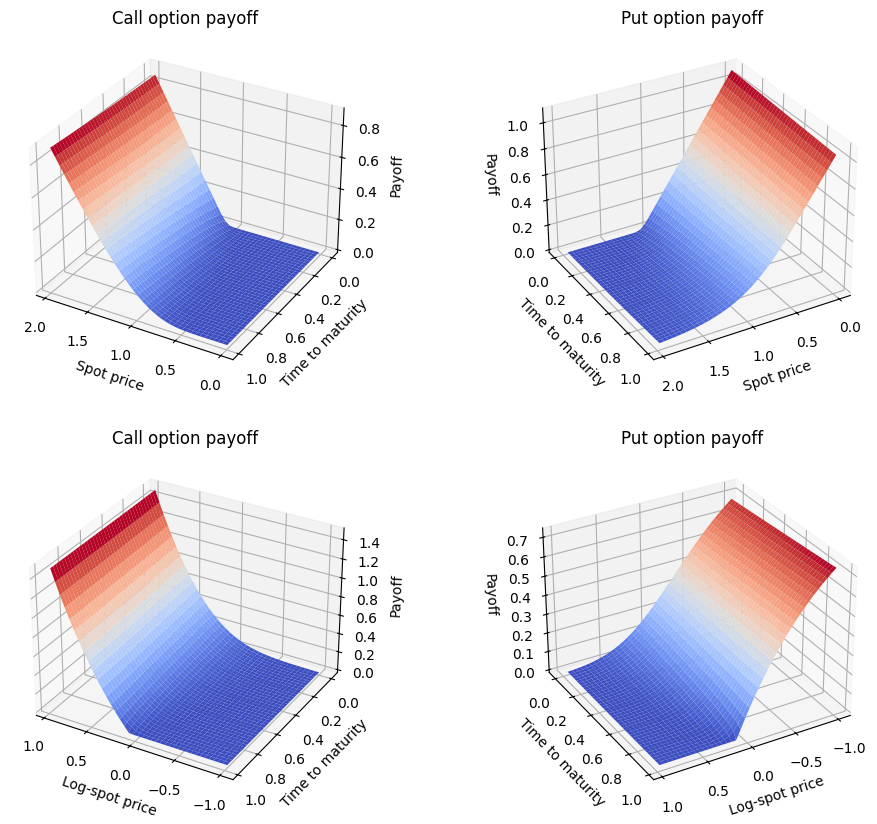

In [29]:
# PAYOFF SURFACE =================================================================================================
St, t = np.meshgrid(np.arange(0.01, 2, 0.05), np.arange(0.01, T, 0.025)) # start from 0.01 to avoid log(0) and divide by 0
d1 = (np.log(St / K) + (R - Q + 0.5 * SIGMA**2) * t) / (SIGMA * np.sqrt(t))
d2 = d1 - SIGMA * np.sqrt(t)
call_payoff_spot = St * np.exp(-Q * t) * stats.norm.cdf(d1) - K * np.exp(-R * t) * stats.norm.cdf(d2)
call_payoff_spot[-1] = np.maximum(St[-1] - K, 0)
put_payoff_spot = K * np.exp(-R * t) * stats.norm.cdf(-d2) - St * np.exp(-Q * t) * stats.norm.cdf(-d1)
put_payoff_spot[-1] = np.maximum(K - St[-1], 0)

# Plot -----------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(2, 2, figsize=(12, 10), clear = True, subplot_kw={"projection": "3d"})

# Analytical solution w.r.t. spot price
ax[0, 0].plot_surface(St, t, bs_call(St, K, R, Q, SIGMA, t), cmap='coolwarm', edgecolor='none')
ax[0, 0].set_title('Call option payoff')
ax[0, 0].set_xlabel('Spot price')
ax[0, 0].set_ylabel('Time to maturity')
ax[0, 0].set_zlabel('Payoff')
ax[0, 0].view_init(30, 120)

ax[0, 1].plot_surface(St, t, bs_put(St, K, R, Q, SIGMA, t), cmap='coolwarm', edgecolor='none')
ax[0, 1].set_title('Put option payoff')
ax[0, 1].set_xlabel('Spot price')
ax[0, 1].set_ylabel('Time to maturity')
ax[0, 1].set_zlabel('Payoff')
ax[0, 1].view_init(30, 60)

# Analytical solution w.r.t. log-spot price
k = np.log(K / S0)
[xt,t] = np.meshgrid(np.arange(-1, 1, 0.05), np.arange(0, T, 0.025))
d2 = (xt - k + (R - Q - 0.5 * SIGMA**2) * (T - t)) / (SIGMA * np.sqrt(T - t))
d1 = d2 + SIGMA * np.sqrt(T - t)
call_payoff_logspot = S0 * (np.exp(xt - Q * (T - t)) * stats.norm.cdf(d1) - np.exp(k - R * (T - t)) * stats.norm.cdf(d2))
call_payoff_logspot[-1] = S0 * np.maximum(np.exp(xt[-1]) - np.exp(k), 0)
put_payoff_logspot = S0 * (np.exp(k - R * (T - t)) * stats.norm.cdf(-d2) - np.exp(xt - Q * (T - t)) * stats.norm.cdf(-d1))
put_payoff_logspot[-1] = S0 * np.maximum(np.exp(k) - np.exp(xt[-1]), 0)

ax[1, 0].plot_surface(xt, t, call_payoff_logspot, cmap='coolwarm', edgecolor='none')
ax[1, 0].set_title('Call option payoff')
ax[1, 0].set_xlabel('Log-spot price')
ax[1, 0].set_ylabel('Time to maturity')
ax[1, 0].set_zlabel('Payoff')
ax[1, 0].view_init(30, 120)

ax[1, 1].plot_surface(xt, t, put_payoff_logspot, cmap='coolwarm', edgecolor='none')
ax[1, 1].set_title('Put option payoff')
ax[1, 1].set_xlabel('Log-spot price')
ax[1, 1].set_ylabel('Time to maturity')
ax[1, 1].set_zlabel('Payoff')
ax[1, 1].view_init(30, 60)

plt.show()

In [30]:
# # FOURIER SOLUTION ===============================================================================================
temp = time()

# Controls


def payoff(x, xi, ALPHA, K, L, U, C, theta):
    '''
    Fourier transform of the payoff function

    Parameters
    ----------
    x : numpy.ndarray
        Grid in real space
    xi : numpy.ndarray
        Grid in Fourier space
    ALPHA : float
        Dampening factor

    Returns
    -------
    S : numpy.ndarray
        Grid in real space
    g : numpy.ndarray
        Payoff function
    G : numpy.ndarray
        Fourier transform of the payoff function
    
    '''
    # Scale
    S = C * np.exp(x)

    # Payoff; see e.g. Green, Fusai, Abrahams 2010, Eq. (3.24)
    g = np.exp(ALPHA * x) * np.maximum(theta * (S - K), 0) * (S >= L) * (S <= U)

    # Analytical Fourier transform of the payoff
    l = np.log(L / C)  # lower log barrier
    k = np.log(K / C)  # log strike
    u = np.log(U / C)  # upper log barrier

    # Integration bounds
    if theta == 1:  # call
        a = max(l, k)
        b = u
    else:  # put
        a = min(k, u)
        b = l

    # Green, Fusai, Abrahams 2010 Eq. (3.26) with extension to put option
    xi2 = ALPHA + 1j * xi
    G = C * ((np.exp(b * (1 + xi2)) - np.exp(a * (1 + xi2))) / (1 + xi2) - (np.exp(k + b * xi2) - np.exp(k + a * xi2)) / xi2)

    # Eliminable discontinuities for xi = 0, otherwise 0/0 = NaN
    if ALPHA == 0:
        G[len(G) // 2] = C * (np.exp(b) - np.exp(a) - np.exp(k) * (b - a))
    elif ALPHA == -1:
        G[len(G) // 2] = C * (b - a + np.exp(k - b) - np.exp(k - a))

    return S, g, G

# Grids in real and Fourier space
N = N_GRIDS // 2
b = X_WIDTH / 2  # upper bound of the support in real space
dx = X_WIDTH / N_GRIDS  # grid step in real space
x = dx * np.arange(-N, N)  # grid in real space
dxi = np.pi / b  # Nyquist relation: grid step in Fourier space
xi = dxi * np.arange(-N, N)  # grid in Fourier space

# Characteristic function at time T
muABM = R - Q - 0.5 * SIGMA**2 # drift coefficient of the arithmetic Brownian motion MARTINGALE CORRECTION

xia = xi + 1j * ALPHA  # call
psi = 1j * muABM * xia - 0.5 * (SIGMA * xia) ** 2  # characteristic exponent
psi_call = np.exp(psi * T)  # characteristic function
xia = xi - 1j * ALPHA  # put
psi = 1j * muABM * xia - 0.5 * (SIGMA * xia) ** 2  # characteristic exponent
psi_put = np.exp(psi * T)  # characteristic function

# Fourier transform of the payoff
b = X_WIDTH / 2  # upper bound of the support in real space
U = S0 * np.exp(b)
L = S0 * np.exp(-b)
_, gc, Gc = payoff(x, xi, ALPHA, K, L, U, S0, 1)  # call
S, gp, Gp = payoff(x, xi, -ALPHA, K, L, U, S0, 0)  # put

# Discounted expected payoff computed with the Plancherel theorem
# c = np.exp(-R * T) * np.real(fftshift(fft(ifftshift(Gc * np.conj(psi_call))))) / X_WIDTH  # call
# call_fourier = interp1d(S, c, kind='cubic')(S0)
# p = np.exp(-R * T) * np.real(fftshift(fft(ifftshift(Gp * np.conj(psi_put))))) / X_WIDTH  # put
# # put_fourier = interp1d(S, p, kind='cubic')(S0)

call_fourier = np.exp(-R * T) / np.pi * np.trapz(np.real(Gc[N:] * np.conj(psi_call[N:]))) * dxi  # call
put_fourier = np.exp(-R * T) / np.pi * np.trapz(np.real(Gp[N:] * np.conj(psi_put[N:]))) * dxi  # call

# interp1d(S, p, kind='cubic')(S0) means that we interpolate the function p(S) at the point S0, S is the grid of the function p(S), S0 is in S

# # ================================================================================================================
t_fourier = time() - temp

In [37]:
# Direct integration in real space
# Integrate directly the payoff times the risk-neutral probability density function in the real space using the trapezoidal rule with N_GRIDS points
temp = time()

N = 64
x = np.linspace(-10, 10, N)  # grid in real space
dx = x[1] - x[0]  # grid step in real space

# Probability density function
pdf = stats.norm.pdf(x, loc = muABM * T, scale = SIGMA * np.sqrt(T))

payoff_call = np.maximum(S0 * np.exp(x) - K, 0)
payoff_put = np.maximum(K - S0 * np.exp(x), 0)

# Discounted expected payoff computed with the trapezoidal rule
call_direct = np.exp(-R * T) * np.trapz(payoff_call * pdf, x, dx)  # call
put_direct = np.exp(-R * T) * np.trapz(payoff_put * pdf, x, dx)  # put

# # ================================================================================================================
t_direct = time() - temp

print(call_direct)
print(put_direct)

0.12948060471608352
0.19563429836005816


In [35]:
# MONTE CARLO SOLUTION ===========================================================================================
temp = time()

call_mc_blocks = np.zeros(N_BLOCKS)
put_mc_blocks = np.zeros(N_BLOCKS)

# Monte Carlo simulation via GBM
for i in range(N_BLOCKS):
    S = (R - Q - 0.5 * SIGMA**2) * T + SIGMA * np.sqrt(T) * np.random.normal(size = N_SIMS)
    S = S0 * np.exp(S)

    call_mc_blocks[i] = np.exp(-R * T) * np.maximum(S - K, 0).mean()
    put_mc_blocks[i] = np.exp(-R * T) * np.maximum(K - S, 0).mean()

# Obtaining the results
call_mc = call_mc_blocks.mean()
put_mc = put_mc_blocks.mean()

# Standard error
call_mc_se = np.sqrt(call_mc_blocks.var() / N_BLOCKS)
put_mc_se = np.sqrt(put_mc_blocks.var() / N_BLOCKS)

# ================================================================================================================
t_mc = time() - temp

In [36]:
# PRINT RESULTS ===================================================================================================
print(f"{'':18s}{'Call':15s}{'Put':15s}{'CPU Time/s':15s}{'Operations':15s}")
print(f"{'BS Analytical':15s}{call_analytical:15.10f}{put_analytical:15.10f}{t_analytical:15.10f}{1:13d}")
print(f"{'Fourier':15s}{call_fourier:15.10f}{put_fourier:15.10f}{t_fourier:15.10f}{N_GRIDS:13d}")
print(f"{'Direct':15s}{call_direct:15.10f}{put_direct:15.10f}{t_direct:15.10f}{N:13d}")
print(f"{'Monte Carlo':15s}{call_mc:15.10f}{put_mc:15.10f}{t_mc:15.10f}{N_BLOCKS * N_SIMS:13d}")
print(f"{'MC S.E.':15s}{call_mc_se:15.10f}{put_mc_se:15.10f}")

                  Call           Put            CPU Time/s     Operations     
BS Analytical     0.1296540132   0.1958077069   0.0009915829            1
Fourier           0.1296540132   0.1958077069   0.0010097027          256
Direct            0.1294806047   0.1956342984   0.0014328957           64
Monte Carlo       0.1296229129   0.1958235176   0.5735852718     20000000
MC S.E.           0.0000606393   0.0000462965
